### Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import IncrementalPCA
import sklearn.metrics as skm

from src.data.preprocess_templates import *
from src.evaluation.visualize import *

### Load Data

In [8]:
REPO_PATH = "/Users/johnzhou/research/spike-sorting"
cluster_fname = f"{REPO_PATH}/data/processed/clusters_k=20/templates.npy"
cluster_templates = np.load(cluster_fname)
cluster_labels = np.load(f"{REPO_PATH}/data/processed/clusters_k=20/unit_idxs.npy")
featurize_templates = np.load(f"{REPO_PATH}/data/processed/featurization_train/templates.npy")

geom_array = np.load(f"{REPO_PATH}/data/raw/channel_map_np2.npy")
n_channels = 20
channels_pos = geom_array[:n_channels]

### Fit PCA

In [4]:
num_latents = 6
print(featurize_templates.shape)
num_samples, num_timesteps, num_channels = featurize_templates.shape
templates_flat = np.reshape(featurize_templates, (num_samples, num_timesteps * num_channels))
ipca = IncrementalPCA(n_components=num_latents)
ipca.partial_fit(templates_flat)

(80000, 20, 121)


IncrementalPCA(n_components=6)

### Get Latent Representation (PCA)

In [5]:
num_samples, num_channels, num_timesteps = cluster_templates.shape
print(cluster_templates.shape)
cluster_templates_flat = np.reshape(cluster_templates, (num_samples, num_timesteps * num_channels))
latent_rep = ipca.transform(cluster_templates_flat)

(20000, 20, 121)


In [14]:
print(latent_rep.shape)

(20000, 6)


### Get Latent Representation (VAE)

In [7]:
from src.models.spike_vae_module import SpikeSortingVAE
from src.evaluation.model_utils import get_latents

In [13]:
expt_path = f"{REPO_PATH}/experiments"
vae_model_path = f"{expt_path}/vae/vae_6latent/model-v1.ckpt"

vae_latent_rep = get_latents(SpikeSortingVAE, vae_model_path, cluster_fname)
print(vae_latent_rep.shape)

(20000, 6)


### Inspect Cluster Dataset

In [29]:
cluster_unique, unique_idxs = np.unique(cluster_labels, return_index=True)
idx_bounds = np.sort(unique_idxs)[1:]
clusters = np.split(cluster_labels, idx_bounds)
clusters = np.vsplit(vae_latent_rep, idx_bounds)
print([cluster.shape for cluster in clusters])

[(1000, 6), (1000, 6), (1000, 6), (1000, 6), (1000, 6), (1000, 6), (1000, 6), (1000, 6), (1000, 6), (1000, 6), (1000, 6), (1000, 6), (1000, 6), (1000, 6), (1000, 6), (1000, 6), (1000, 6), (1000, 6), (1000, 6), (1000, 6)]


In [30]:
from scipy.spatial.distance import cdist

num_clusters = len(clusters)
neg_conf_matrix = np.zeros((num_clusters, num_clusters))
eval_metric = 'l2'

for i, cluster_a in enumerate(clusters):
    for j, cluster_b in enumerate(clusters):
        inter_cluster_dists = pairwise_distances(cluster_a, cluster_b, metric=eval_metric)
        avg_inter_cluster_dist = np.mean(inter_cluster_dists)
        neg_conf_matrix[i, j] = avg_inter_cluster_dist
        neg_conf_matrix[j, i] = avg_inter_cluster_dist

avg_intra_cluster_dists = np.mean(np.diagonal(neg_conf_matrix))
neg_conf_matrix /= avg_intra_cluster_dists

min_dist = np.min(neg_conf_matrix, axis=0)
rearrange = np.argsort(min_dist)
neg_conf_matrix = neg_conf_matrix[rearrange, :]
neg_conf_matrix = neg_conf_matrix[:, rearrange]
print("min:", np.min(neg_conf_matrix), "max:", np.max(neg_conf_matrix), 
      "median:", np.median(neg_conf_matrix), "mean:", np.mean(neg_conf_matrix))

min: 0.28274210194632254 max: 24.455646786808998 median: 6.571016473904298 mean: 7.646110249196124


Text(0.5, 1.0, 'Average distance matrix between synthetic clusters (VAE)')

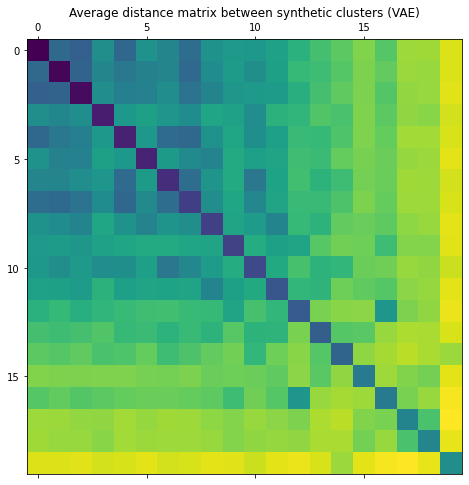

In [33]:
fig, (ax1) = plt.subplots(ncols=1, figsize=(8, 8))
ax1.matshow(np.log(neg_conf_matrix))

# add the title and label
ax1.set_title('Average distance matrix between synthetic clusters (VAE)')

/Users/johnzhou/anaconda3/envs/yass/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


Text(0.5, 1.0, 'Distance matrix with 5 representative spikes from each cluster (VAE)')

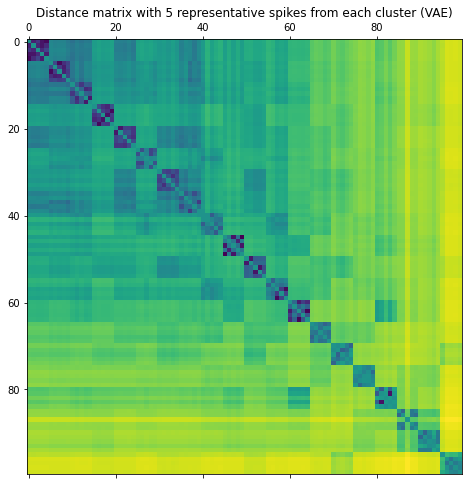

In [37]:
import math

five_from_each = [cluster[:5, :] for cluster in clusters]
five_from_each = np.stack(five_from_each)
# Sort by same min dist as clusters
five_from_each = np.reshape(five_from_each[rearrange, :, :], (100, 6))
fives_neg_conf_matrix = pairwise_distances(five_from_each, metric=eval_metric)
log_matrix = np.log(fives_neg_conf_matrix)
log_matrix[np.where(np.isneginf(log_matrix))] = 0


fig, (ax1) = plt.subplots(ncols=1, figsize=(8, 8))
ax1.matshow(log_matrix)

# add the title and label
ax1.set_title('Distance matrix with 5 representative spikes from each cluster (VAE)')


In [36]:
spike_idx = np.random.randint(fives_neg_conf_matrix.shape[0])
print(spike_idx)
neighbors = np.argsort(fives_neg_conf_matrix[spike_idx, :])
print(neighbors)

51
[51 50 52 53 54 33 31 30 32 34 39 36 37 35 38 19 16 17  5 21  7 18  9 20
 24 23 22  8 15  6 40 10 12  1  2 42  3  0  4 13 14 29 11 25 28 26 43 59
 57 44 27 58 72 41 45 49 47 56 71 68 55 48 46 65 73 69 67 66 74 70 63 62
 60 64 61 75 80 78 81 83 77 76 79 93 82 84 85 86 92 89 88 91 94 90 95 99
 87 97 98 96]


In [11]:
def get_og_spike_idx(idx, num_from_each=5, num_per_cluster=1000):
    cluster_idx = idx // num_from_each
    spike_idx = idx % num_from_each
    return cluster_idx * num_per_cluster + spike_idx

48
9003
[ 9003  9001  9000  9002  6003  9004  8003  6004  8004 11004]
Template 0


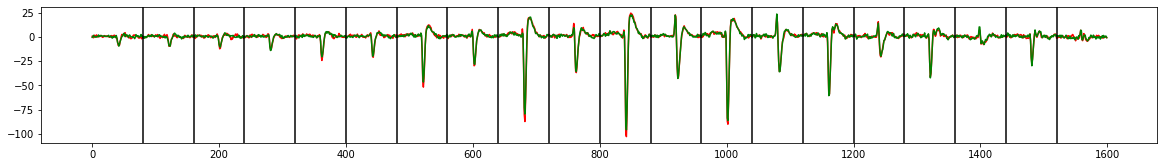

Template 1


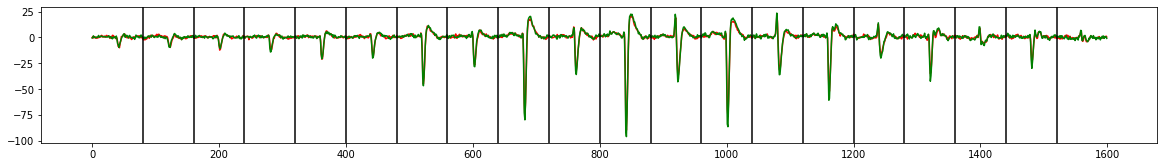

Template 2


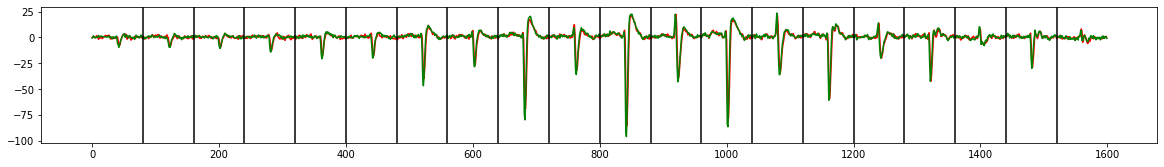

Template 3


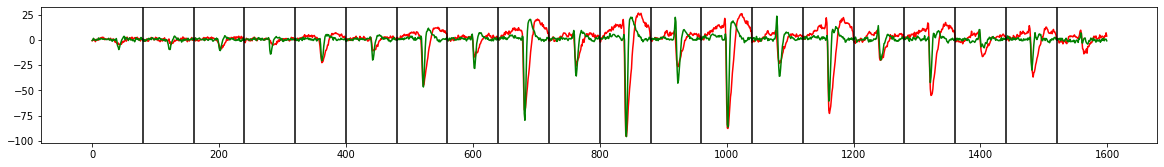

Template 4


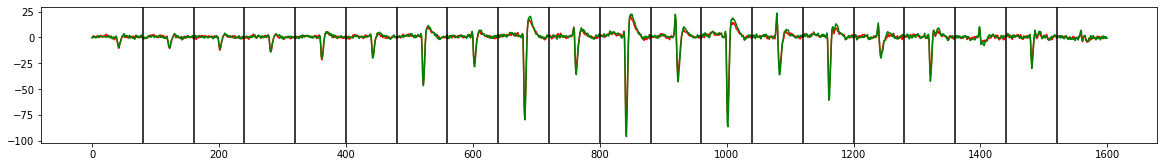

Template 5


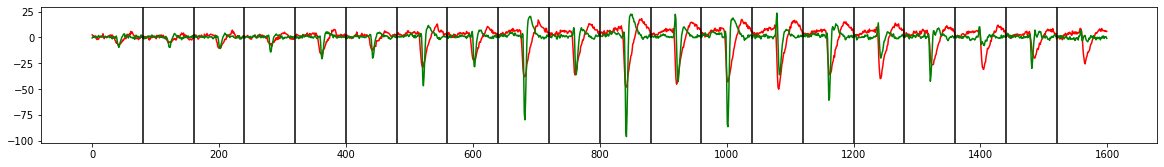

Template 6


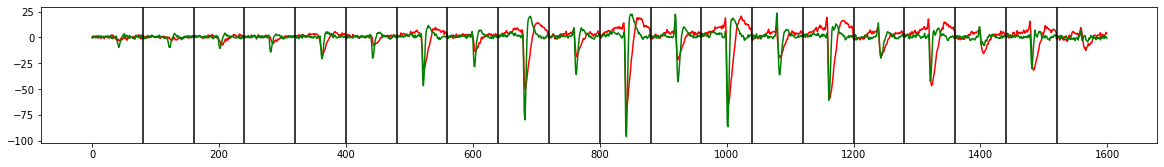

Template 7


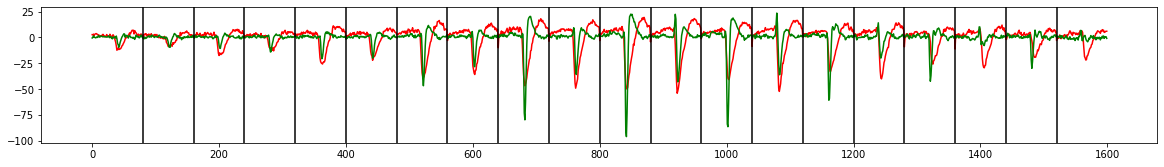

Template 8


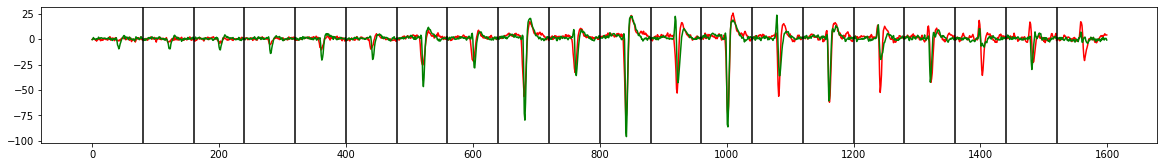

In [22]:
print(spike_idx)
og_spike_idx = get_og_spike_idx(spike_idx)
print(og_spike_idx)
og_neighbors_idxs = get_og_spike_idx(neighbors[:10])
print(og_neighbors_idxs)
close = cluster_templates[og_neighbors_idxs[1:10], :].swapaxes(1, 2)
base = cluster_templates[og_neighbors_idxs[0], :].swapaxes(0, 1)
plot_templates(close, base_template=base)

(5, 121, 20)
Template 0


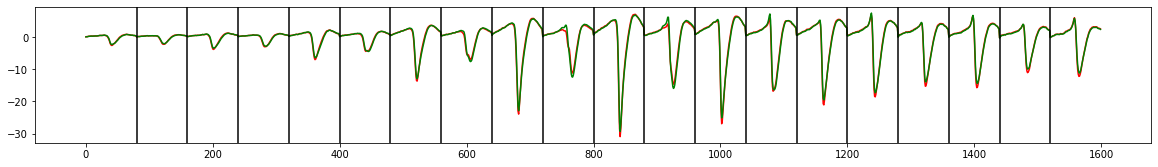

Template 1


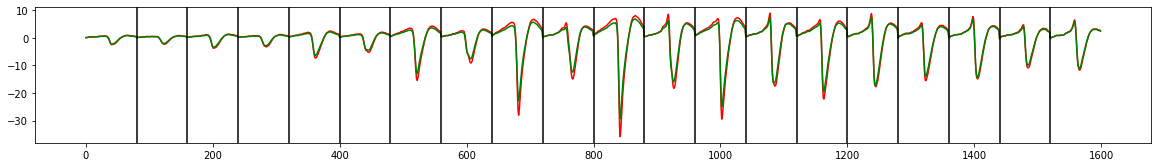

Template 2


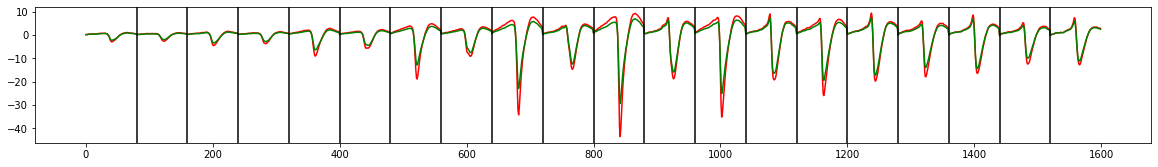

Template 3


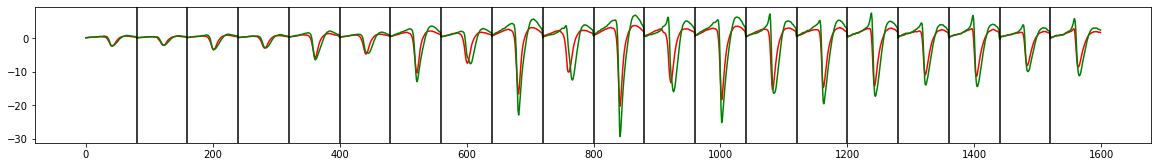

In [21]:
closest = five_from_each[neighbors[:5], :]
furthest = five_from_each[neighbors[-5:], :]
close_reconstructions = np.reshape(ipca.inverse_transform(closest), (5, num_channels, num_timesteps))
close_reconstructions = np.swapaxes(close_reconstructions, 1, 2)
print(close_reconstructions.shape)

plot_templates(close_reconstructions[1:5], base_template=close_reconstructions[0])
# fig = plt.figure(figsize=(n_channels, 2.5))
# for i in range(1, 5):
#     plt.plot(close_reconstructions[i, :80, :].T.flatten(), color='red')
# plt.plot(close_reconstructions[0, :80, :].T.flatten(), color='blue')

# for j in range(n_channels - 1):
#     plt.axvline(80 + 80 * j, color='black')